In [1]:
# import necessary libraries
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from textblob import TextBlob
try:
    import subprocess
except:
    %pip install subprocess
    import subprocess
import numpy as np
import findspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from collections import namedtuple

In [ ]:
#Importing relevant packages
import findspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext

#initialising spark directory
findspark.init('Spark directory on your system') 

In [2]:
findspark.init('C:\opt\spark') #initialise spark directory
sc = SparkContext() #make new spark session
ssc = StreamingContext(sc, 10) #we initiate the StreamingContext with 10 second batch interval
sqlContext = SQLContext(sc) #next we initiate our sqlcontext
socket_stream = ssc.socketTextStream("127.0.0.1", 5555) #initiate streaming text from a TCP (socket) source:
lines = socket_stream.window(60) #lines of tweets with socket_stream window of size 60, or 60 #seconds windows of time

In [ ]:
#create new spark session
sc = SparkContext() 
#initiating the StreamingContext with 10 second batch interval
ssc = StreamingContext(sc, 10)
#next we initiate our sqlcontext
sqlContext = SQLContext(sc) 

In [ ]:
#initiate streaming text from a TCP (socket) source:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555) 
#lines of tweets with socket stream window of size 60 (60 seconds of time)
lines = socket_stream.window(60) 

In [3]:
#create tuple for hashtag and counting and a named tuple Tweet
hashtagfield = ("hashtag", "count")
Tweet = namedtuple('Tweet', hashtagfield)

#create tuple for sentiment analysis with text and count and a named tuple Sentiment
sentifields = ("text", "count")
Sentiment = namedtuple('Sentiment', sentifields)

In [ ]:
#create tuple for hashtag and counting and a named tuple Tweet
hashtagfield = ("hashtag", "count")
Tweet = namedtuple('Tweet', hashtagfield)

### Transformation on the incoming streaming data ###
#Splits to a list
text = lines.flatMap(lambda text: text.split(" ")) 
#Filter hashtag calls 
hashtag = text.filter(lambda word: word.lower().startswith("#")) 
#Lower cases the word
lowerWord = hashtag.map(lambda word: (word.lower(), 1 )) 
#sum up the count of equal hashtags
getCount = lowerWord.reduceByKey(lambda a, b: a + b) 
#stores the tuple in named tuple Tweet
store = getCount.map(lambda rec: Tweet(rec[0], rec[1])) 
#Sorts RDDs by hashtag count, registers only top 5 hashtags and saves them to a temporary sql table
store.foreachRDD(lambda rdd: rdd.toDF().sort(desc("count")).limit(5).registerTempTable("tweets")) 

In [4]:
sentences = lines.flatMap( lambda text: text.split( "\n" ) ) #Splits to a list containing of the single tweets 
table = sentences.map( lambda word: ( word, 1) )  #saves them in a tupel 
sent = table.map( lambda rec: Sentiment( rec[0], rec[1] ) ) #stores the tupel in named tupel Sentiment
sent.foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ).limit(10000).registerTempTable("sentiment")) #save RDDs to a temporary sql table 

text = lines.flatMap(lambda text: text.split(" ")) #Splits to a list
hashtag = text.filter(lambda word: word.lower().startswith("#"))  #Filter hashtag calls  
lowerWord = hashtag.map(lambda word: (word.lower(), 1 )) #Lower cases the word
getCount = lowerWord.reduceByKey(lambda a, b: a + b) #sum up the count of equal hashtags
store = getCount.map(lambda rec: Tweet(rec[0], rec[1])) #stores the tupel in named tupel Tweet
store.foreachRDD(lambda rdd: rdd.toDF().sort(desc("count")).limit(5).registerTempTable("tweets")) #Sorts RDDs by hashtag count, registers only top 5 hashtags and saves them to a temporary sql table

In [5]:
#get user input for search
while True:
    search = input("Enter searchword: ")
    if(search != ""):
        print("Search for: " + search)
        break
    print("You have to use a searchword!")

search = search.split(",") #splits user input by ","

f = open("var.py", "w") #opens another file to store search variable 
f.write("search = %s" % search) #overwrite the file
f.close()

#opens job.sh in shell command, which then calls the TweetsReceiver
file = subprocess.Popen("job.sh", shell = True)  

ssc.start() #starts streaming

Enter searchword: racism
Search for: racism


In [6]:
#has to wait 60 seconds to get enough tweets for RDDs because socket_stream.window(60) is set to 60 seconds
print("Wait 60 seconds for data to stream properly...")
time.sleep(60)
print("...successfull")

Wait 60 seconds for data to stream properly...
...successfull


In [ ]:
### Top 5 hashtags ###

#queries the temporary sql table and stores the result in a variable
top_5_tags = sqlContext.sql('Select hashtag, count from tweets') 
#converts SQL variable to a pandas dataFrame
top_5_df = top_5_tags.toPandas() 

#Visualization
plt.figure( figsize = (10, 8))
sns.barplot( x="count", y="hashtag", data=top_5_df)
plt.show()

In [ ]:
### Sentiment Analysis ###

import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob #package for simple sentiment analysis

#gets temporary sql table and stores it in file
senti = sqlContext.sql('Select text from sentiment') 
#convert file to pandas dataFrame
sen = senti.toPandas()

In [ ]:
#array for counting positive and negative tweets 
countPosNegNeu = np.array([0, 0, 0]) 

while i < len(sen):
    #compute sentiment analysis on clean text and store it in opinion
    opinion = TextBlob(formatText(sen["text"][i])) 
    
    #print 5 tweets with sentiment analysis
    if(s <= 5):
        print("For the text: ", formatText(sen["text"][i]))
        print("The text polarity is: %.2f" %opinion.sentiment[0])
        print("The text subjectivity is: %.2f" %opinion.sentiment[1])
        print("*****************************************************")
    
    #store tweets in positive/negative/neutral polarity list
    if(opinion.sentiment[0] > 0):
        #add 1 to positive count because sentiment was positive
        countPosNegNeu[1] += 1 
    elif(opinion.sentiment[0] < 0):
        #add 1 to negative count because sentiment was negative
        countPosNegNeu[0] += 1 
    else:
        #add 1 to neutral count because sentiment was neither negative nor positive
        countPosNegNeu[2] += 1 
    i += 1 #count +1 for while loop
    s += 1 #count +1 for text printing

In [ ]:
#print positive/negative/neutral barplot
print("Positive/Negative Barplot")
plt.figure(figsize = (10, 8))
sns.barplot(x=countNames, y=countPosNegNeu)
plt.show()

#print positive/negative/neutral boxplot
print("Positive/Negative/Neutral Boxplot")
boxplotdata = pandas.DataFrame(list(zip(negativeList, positiveList)), columns =['negative', 'positive'])
plt.figure(figsize = (10, 8))
sns.boxplot(data = boxplotdata)
plt.show()

In [ ]:
#format text for clear output
def formatText(text):
    formatted_text = ' '.join(word for word in text.split() if (word[0]!='#' and 
                                           word[0]!="@" and 
                                           not word.startswith("http") and 
                                           not word.startswith("RT")))
    return formatted_text

In [ ]:
#Get hashtags count from temporary SQL table and plot it
def plot():
    ploterror = int() #set error variable
    #if try is successful it plot top 5 hashtags and calls sentiment() for sentiment analysis
    try:
        %matplotlib inline
        print("Gather Data for graph...")
        time.sleep(5)
        #top 5 hashtags:
        top_5_tags = sqlContext.sql('Select hashtag, count from tweets') #gets temporary sql table and stores it in file
        top_5_df = top_5_tags.toPandas() #convert file to pandas dataFrame
        print("...successful")
        print("")
        plt.figure( figsize = (10, 8))
        sns.barplot( x="count", y="hashtag", data=top_5_df)
        plt.show()
        plt.clf()
        sentiment()
    #if try is not successful set error variable to +1 and try plot() again. If error exceeds 5 then exit()
    except:
        print("Data was not ready for printing....waiting....")
        time.sleep(20)
        if(ploterror >= 5):
            print("Error on Streaming")
            print("Exiting...")
            ssc.stop()
            exit()
        ploterror += 1
        plot()
        
#Does sentiment analysis on the twitter text
def sentiment():
    sentierror = int() #defines error variable
    %matplotlib inline
    #if try is successful it does sentiment analysis on the twitter text, prints 5 tweets and plots the polarity count if the overall search topic is neutral/positive/negative
    try:
        print("Gather data for Sentiment Analysis...")
        #sentiment analysis:
        senti = sqlContext.sql('Select text from sentiment') #gets temporary sql table and stores it in file
        sen = senti.toPandas() #convert file to pandas dataFrame
        sen.dropna(inplace=True)
        sen.reset_index(drop=True, inplace=True)
        print("successful")
        #sen['text'].replace("", np.nan, inplace=True)
        #sen.dropna(inplace=True)
        dfLen = len(sen) #get number of rows
        positiveList = [] #empty list for storing positive tweets
        negativeList = [] #empty list for storing negative tweets
        neutralList = [] #empty list for storing neutral tweets
        countPosNegNeu = np.array([0, 0, 0]) #array for counting positive and negative tweets --> 0 is negative, 1 is positive, 2 is neutral
        countNames = np.array(["negative", "positive", "neutral"]) #names for plotting
        s = 0 #count variable for plotting 5 tweets with sentiment analysis
        i = 0 #count variable to get every tweet out of sen dataFrame
        print("analyse text for sentiment...")
        try:
            while i < dfLen:
                if((TextBlob(formatText(sen["text"][i])).sentiment[0] == 0.0) and (TextBlob(formatText(sen["text"][i])).sentiment[1] == 0.0)):
                   i += 1 #count +1 for while loop
                   s += 1 #count +1 for text printing
                else:
                    opinion = TextBlob(formatText(sen["text"][i])) #compute sentiment analysis on clean text and store it in opinion
                    #print 5 tweets with sentiment analysis
                    if(s <= 5):
                        print("For the text: ", formatText(sen["text"][i]))
                        print("The text polarity is: %.2f" %opinion.sentiment[0])
                        print("The text subjectivity is: %.2f" %opinion.sentiment[1])
                        print("*****************************************************")
                    #store tweets in positive/negative/neutral polarity list
                    if(opinion.sentiment[0] > 0):
                        countPosNegNeu[1] += 1 #add 1 to positive count because sentiment was positive
                        positiveList.append(opinion.sentiment[0]) #stores tweet in positive list
                    elif(opinion.sentiment[0] < 0):
                        countPosNegNeu[0] += 1 #add 1 to negative count because seintiment was negative
                        negativeList.append(opinion.sentiment[0]) #stores tweet in negative list
                    else:
                        countPosNegNeu[2] += 1 #add 1 to neutral count because seintiment was not negative or positive
                        neutralList.append(opinion.sentiment[0]) #stores tweet in neutral list
                    i += 1 #count +1 for while loop
                    s += 1 #count +1 for text printing
        except:
            pass
        
        print("...done!")
        print("")
        #print positive/negative/neutral barplot
        try:
            print("Positive/Negative Barplot")
            plt.figure(figsize = (10, 8))
            sns.barplot(x=countNames, y=countPosNegNeu)
            plt.show()
            plt.clf() #cleans plot for new plotting
        
            #print positive/negative/neutral boxplot
            print("Positive/Negative/Neutral Boxplot")
            boxplotdata = pandas.DataFrame(list(zip(negativeList, positiveList)), columns =['negative', 'positive'])
            plt.figure(figsize = (10, 8))
            sns.boxplot(data = boxplotdata)
            plt.show()
            plt.clf()
            time.sleep(10)
        except:
            pass
        
        #if user wants to do another analysis on same search word execute plot() again
        if(input("continue?(y/n): ") == "y"):
            plot()
        else:
            print("Exiting...")
            ssc.stop()
            exit()
    #if try is not successful set error variable to +1 and try sentiment() again. If error exceeds 5 then exit()
    except:
        print("Data was not ready for sentiment...waiting...")
        time.sleep(20)
        if(sentierror >= 5):
            print("Error on sentiment, getting not enough data!")
            print("Exiting...")
            ssc.stop()
            exit()
        sentierror += 1
        sentiment()

Gather Data for graph...
...successful



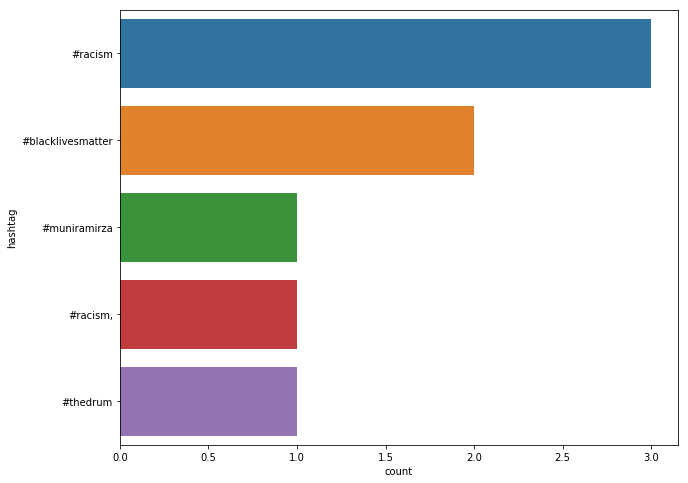

Gather data for Sentiment Analysis...
successful
analyse text for sentiment...
For the text:  WTF, brave! If yer speak out about the industrial rape of a whole generation of British children by majority pakistani moslem men yer labelled a racist and face being jailed, these multi millionaire champagne socialists are not brave 😡🇬🇧🔱 NFSE!
The text polarity is: 0.04
The text subjectivity is: 0.68
*****************************************************
...done!

Positive/Negative Barplot


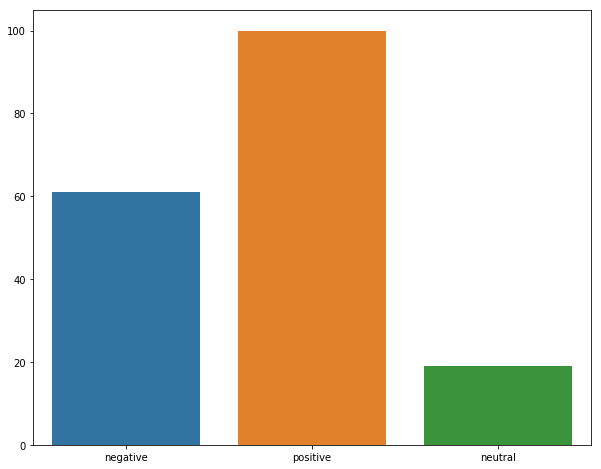

Positive/Negative/Neutral Boxplot


<Figure size 432x288 with 0 Axes>

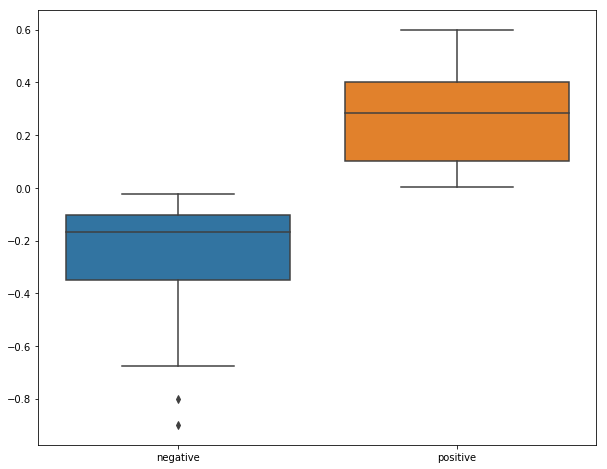

In [ ]:
plot()